In [1]:
import numpy as np
from scipy import integrate
import matplotlib.animation
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
import math
from math import *
from numpy.random import random

In [2]:
r=6366197 # Erdradius
g=9.81  # Erdbeschleunigung
cw=0.42  # Widerstandsbeiwert
R=8.214   # allg. Gaskonstante
p0=1.225  #Luftdichte am Erdboden
M=0.02896  #mittlere molare Masse

#variabler Luftdruck ist vorhanden? Wenn nein muss geändert werden
h0=120000 #Starthöhe120km
v0=15000 # Geschwindigkeit 15 mk/s
T=223 # Temperatur in 80km ca. -50◦C

# Dichte, Masse, Querschnitt
d=0.1
pFe=7860
parts=int(3+random(1)*3) #zerspringt in parts Teile zufällig zwischen 3 und 5
print(parts) 
# Durchmesser 1 cm # Dichte von Eisen
m=pFe*d*d*d*pi/6    # Masse
A=d*d*pi/4  # Querschnittsfläche
alpha=np.sin(1/20*pi)     #Eintrittswinkel in rad
d_new=(((6/parts)*m)/(pFe*pi))**(1/3)  #neuer Durchmesser, wenn in parts gleich große Teile geteilt wird
m_new=(1/parts)*m
A_new=d_new*d_new*pi/4

t=0.1     #Zeitintervall
abweichung_crash=0.1  #wie 'groß' die Streuung der Teile ist
winkel=np.linspace(-abweichung_crash,abweichung_crash, parts)
print(winkel)

4
[-0.1        -0.03333333  0.03333333  0.1       ]


In [3]:
def dichte(h):
    p=p0*exp(-M*g*h/(R*T)) # barometrische  Formel
    return(p)

def beschl(h, v, A):   # Beschleunigung für die Höhe ggfs. noch für die x-Achse nötig, u.a. g entfällt da. 
    p=dichte(h)
    a=-p*cw*A*v*v/(2*m)     # Anteil  Luftwiderstand  ...
    a=a+g*(r/(r+h))**2  # Anteil  Gravitation
    return(a)


def beschl_x(h, v, A):   # Beschleunigung für die Höhe ggfs. noch für die x-Achse nötig, u.a. g entfällt da. 
    p=dichte(h)
    a=-p*cw*A*v*v/(2*m)     # Anteil  Luftwiderstand  ...
    return(a)


def compute_x_h(startX, startH, startV, startVX, zeitschritt, 
                durchmesser, masse, querflaeche, winkel,crash):
    h,v,t,a,ax,x,vx,k, aTotal=[],[],[],[],[],[],[],[],[]
    h.append(startH)
    beta=np.tan(startVX/startV)
    v_total=math.sqrt(startV**2+startVX**2)
    v.append(np.cos(beta+winkel)*v_total)
    vx.append(np.sin(beta+winkel)*v_total)
    t.append(0)
    x.append(startX)
    z=0
    #if crash: 
    vH=v[z]
    aMax=0
    while ((h[z]>=0)&(z<100000)):
        vH=v[z]
        a.append(beschl(h[z],v[z],querflaeche))
        if aMax<-a[z]:
            aMax=-a[z]
            zAmax=z
        ax.append(beschl_x(h[z],vx[z],querflaeche))
        aTotal.append(ax[z]+a[z])
        h.append(h[z]-v[z]*zeitschritt)  
        x.append(x[z]+vx[z]*zeitschritt)
        v.append(v[z]+a[z]*zeitschritt)
        if abs(vx[z])>0.00001:
            k.append(1/2*dichte(h[z])*cw*A)
            vx.append(1/((k[z]/m)*z*zeitschritt+(1/vx[z]))) #https://matheplanet.com/default3.html?call=article.php?sid=735&ref=https%3A%2F%2Fwww.google.com%2F
        else: 
            k.append(0)
            vx.append(0)
        t.append(t[z]+zeitschritt)
        z=z+1
    a.append(beschl(h[z],v[z],querflaeche))
    hCrash=h[z]
    if crash:
        global ls, h_crash
        ls=aTotal.index(max(aTotal))-1
        h_crash=h[ls]
    return(h,v,t,a,x,vx)

def computeRoute(i):
    len_met=[]
    for k in range(parts):
        len_met.append(len(stat_met[k][0]))
    max_len=max(len_met)
    if i<ls:
        RoutePreCrash=[]
        RoutePreCrash.append([x_start[i],h_start[i]])
        for _ in range(parts+1):
            RoutePreCrash.append([np.nan,np.nan])
        
        return(RoutePreCrash)     #vor Zerfall Route
    if i==ls:
        routeInCrash=[]
        routeInCrash.append([x_start[i],h_start[i]])
        routeInCrash.append([x_start[i],h_start[i]])
        for k in range(parts):
            routeInCrash.append([stat_met[k][4][0],stat_met[k][0][0]])
        return(routeInCrash)
    j=i-ls
    routeAfCrash=[]
    routeAfCrash.append([np.nan,np.nan])
    if len(h_start)>i:
        routeAfCrash.append([x_start[i],h_start[i]])
    else:
        routeAfCrash.append([x_start[len(h_start)-1],h_start[len(h_start)-1]])
        
    for k in range(parts):
        if len_met[k]>j: 
            routeAfCrash.append([stat_met[k][4][j],stat_met[k][0][j]])
        else:
            routeAfCrash.append([stat_met[k][4][len_met[k]-1],stat_met[k][0][len_met[k]-1]])
    return(routeAfCrash)


In [4]:
#original Meteorit
h_start,v_start,t_start,a_start,x_start,vx_start= compute_x_h(startX=0, startH=h0, startV=v0, startVX=0,
                                                              zeitschritt=t, durchmesser=d, masse=m, 
                                                              querflaeche=A, winkel=alpha,crash=True)

#1. Teilstück
stat_met=[]
for i in range(parts):
    stat_met.append(compute_x_h(startX=x_start[ls], startH=h_start[ls], startV=v_start[ls], 
                               startVX=vx_start[ls],zeitschritt=t, durchmesser=d_new,masse=m_new, 
                                querflaeche=A_new, winkel=winkel[i],crash=False))
    


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


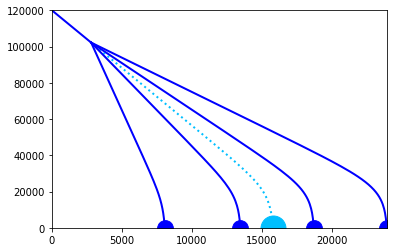

In [8]:
frames=max(len(stat_met[0][0])+ls,len(h_start))+50 #Länge video
sizeMet=25*(d/d)
sizeParts=25*(d_new/d)  #um die richtigen Größen für die meteoren zu haben
max_x_met,min_x_met=[],[] 
for k in range(parts):
    max_x_met.append(max(stat_met[k][4]))
    min_x_met.append(min(stat_met[k][4])) #berechne, wie weit x und y sind
min_x_met.append(0)
fig = plt.figure() 
ax = plt.axes(xlim=(min(min_x_met),max(max_x_met)),ylim=(0, h0)) # sorge dafür, dass man alles sieht, achsen einstellen
line, = ax.plot([], [],'-', lw=2,c='b')   #für Linien original Meteorit
line_dash, = ax.plot([], [],':', lw=2,c='deepskyblue') #dash der original Meteorit nach dem Zerfall
lineMet,ptMet=[],[]
for i in range(parts): #die Punkte und linien für die Stücke werden festgelegt
    lineMet.append(ax.plot([], [],'-', lw=2,c='b'))
    ptMet.append(ax.plot([], [],'o', ms=sizeParts,c='b'))
pt, = ax.plot([], [],'o', ms=sizeMet,c='b') #Für Punkte vor Zerfall
pt_dash, = ax.plot([], [],'o', ms=sizeMet,c='deepskyblue')
#ggfs. noch Geschwindigkeiten in Legende/Beschreibung?
def init(): #alles 
    plots=[]
    line.set_data([], []) 
    pt.set_data([], []) 
    line_dash.set_data([], []) 
    pt_dash.set_data([], []) 
    for k in range(parts):
        lineMet[k][0].set_data([], [])
        ptMet[k][0].set_data([], [])

    plots.append(line)
    plots.append(pt)
    plots.append(line_dash)
    plots.append(pt_dash)
    for k in range(parts):
        plots.append(lineMet[k][0])
        plots.append(ptMet[k][0])
    return plots

xdata, ydata = [], [] 
xdash, ydash = [], [] 
xMet,yMet=[],[]

for k in range(parts):
    xMet.append([])
    yMet.append([])
# animation function 
def animate(i): 
    # t is a parameter 

    t = 0.05*i 
    s=computeRoute(i)
    # x, y values to be plotted 
    x = s[0][0] 
    y = s[0][1] 

    for k in range(parts):
        xMet[k].append(s[k+2][0])
        yMet[k].append(s[k+2][1])
    
    # appending new points to x, y axes points list 
    xdata.append(x) 
    ydata.append(y) 
    xdash.append(s[1][0]) 
    ydash.append(s[1][1])
    line.set_data(xdata, ydata)
    line_dash.set_data(xdash, ydash)
    
    for k in range(parts):
        lineMet[k][0].set_data(xMet[k],yMet[k])
        ptMet[k][0].set_data(s[k+2][0],s[k+2][1])

    pt.set_data(x, y) 
    pt_dash.set_data(s[1][0], s[1][1])
    plots=[]
    plots.append(line)
    plots.append(pt)
    plots.append(line_dash)
    plots.append(pt_dash)
    for k in range(parts):
        plots.append(lineMet[k][0])
        plots.append(ptMet[k][0])
        
    return line,pt
 
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=frames, interval=20, blit=True) 

# save the animation as mp4 video file 
anim.save('Meteorit.gif',writer='imagemagick') 

plt.savefig('Meteorit.eps')
plt.savefig('Meteorit.jpg')